In [5]:
import pandas as pd
import random
from datetime import datetime, timedelta

In [6]:
# Définition des tweets et des catégories
tweets = [
    "J'adore le football et la Ligue des Champions est incroyable ! #UCL #Football",
    "Le Bitcoin a encore explosé cette semaine, faut-il investir ? #Crypto #BTC",
    "Les voitures électriques vont dominer le marché automobile. #Tesla #EV",
    "Quel est le meilleur téléphone en 2025 ? #Tech #Smartphone",
    "L'intelligence artificielle est en train de révolutionner le monde. #AI #Tech",
    "Netflix sort une nouvelle série demain, hâte de voir ça ! #Netflix #Streaming",
    "Elon Musk vient d'annoncer une nouvelle mise à jour pour Tesla. #Tesla #Tech",
    "La bourse est en chute libre aujourd'hui, inquiétant ! #Finance #Trading",
    "Les montres connectées sont devenues un must-have en 2025. #Tech #Wearables",
    "Quel est le top 10 des livres à lire absolument cette année ? #Books #Reading",
    "neymar"
]

categories = ['Sport', 'Finance', 'Tech', 'Tech', 'Tech',
             'Entertainment', 'Tech', 'Finance', 'Tech', 'Culture']

In [7]:
# Génération des données
usernames = [f"user_{i}" for i in range(1, len(tweets) + 1)]
retweets = [random.randint(10, 1000) for _ in range(len(tweets))]
likes = [random.randint(50, 5000) for _ in range(len(tweets))]
timestamps = [(datetime.now() - timedelta(days=random.randint(1, 365))).strftime("%Y-%m-%d %H:%M:%S")
             for _ in range(len(tweets))]

In [8]:
# Création du DataFrame
df_tweets = pd.DataFrame({
    "Tweet_ID": range(1, len(tweets) + 1),
    "Username": usernames,
    "Text": tweets,
    "Category": categories,
    "Retweets": retweets,
    "Likes": likes,
    "Timestamp": timestamps
})

# Conversion de la colonne Timestamp en datetime
df_tweets['Timestamp'] = pd.to_datetime(df_tweets['Timestamp'])

In [10]:
# Pour afficher toutes les lignes
pd.set_option('display.max_rows', None)
print("Dataset Fictif de Tweets :")
display(df_tweets)

Dataset Fictif de Tweets :


,Tweet_ID,Username,Text,Category,Retweets,Likes,Timestamp
0,1,user_1,J'adore le football et la Ligue des Champions ...,Sport,326,4291,2024-06-06 11:01:27
1,2,user_2,"Le Bitcoin a encore explosé cette semaine, fau...",Finance,158,2157,2025-02-25 11:01:27
2,3,user_3,Les voitures électriques vont dominer le march...,Tech,121,4066,2024-03-30 11:01:27
3,4,user_4,Quel est le meilleur téléphone en 2025 ? #Tech...,Tech,73,3056,2024-05-23 11:01:27
4,5,user_5,L'intelligence artificielle est en train de ré...,Tech,656,592,2024-09-29 11:01:27
5,6,user_6,"Netflix sort une nouvelle série demain, hâte d...",Entertainment,745,3139,2024-05-30 11:01:27
6,7,user_7,Elon Musk vient d'annoncer une nouvelle mise à...,Tech,885,4330,2024-09-22 11:01:27
7,8,user_8,"La bourse est en chute libre aujourd'hui, inqu...",Finance,685,1285,2025-02-14 11:01:27
8,9,user_9,Les montres connectées sont devenues un must-h...,Tech,731,656,2024-12-20 11:01:27
9,10,user_10,Quel est le top 10 des livres à lire absolumen...,Culture,116,253,2024-08-31 11:01:27


In [11]:
df_tweets.to_csv('tweets_dataset.csv', index=False)

# Pretraitement des données

In [ ]:
# Import des bibliothèques nécessaires
%pip install emoji
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from emoji import demojize

     |████████████████████████████████| 590 kB 8.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [14]:
# Cellule 2 : Téléchargement des ressources NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialisation des outils
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('french'))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/barrysalam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/barrysalam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/barrysalam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/barrysalam/nltk_data...


In [15]:

def preprocess_tweet(text):
    """
    Fonction de prétraitement des tweets
    """
    # Conversion en minuscules
    text = text.lower()

    # Suppression des URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Suppression des mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # Suppression des hashtags
    text = re.sub(r'#\w+', '', text)

    # Suppression des emojis
    text = demojize(text)
    text = re.sub(r':[a-zA-Z_]+:', '', text)

    # Suppression des caractères spéciaux et des chiffres
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Suppression des stop words et lemmatisation
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Rejoindre les tokens en une chaîne
    return ' '.join(tokens)

In [16]:
df_tweets['Text_Clean'] = df_tweets['Text'].apply(preprocess_tweet)

In [17]:
print("Comparaison des tweets avant/après prétraitement :")
for original, cleaned in zip(df_tweets['Text'].head(), df_tweets['Text_Clean'].head()):
    print("\nOriginal :", original)
    print("Nettoyé  :", cleaned)

Comparaison des tweets avant/après prétraitement :

Original : J'adore le football et la Ligue des Champions est incroyable ! #UCL #Football
Nettoyé  : jadore football ligue champion incroyable

Original : Le Bitcoin a encore explosé cette semaine, faut-il investir ? #Crypto #BTC
Nettoyé  : bitcoin a encore explosé cette semaine fautil investir

Original : Les voitures électriques vont dominer le marché automobile. #Tesla #EV
Nettoyé  : voitures électriques vont dominer marché automobile

Original : Quel est le meilleur téléphone en 2025 ? #Tech #Smartphone
Nettoyé  : quel meilleur téléphone

Original : L'intelligence artificielle est en train de révolutionner le monde. #AI #Tech
Nettoyé  : lintelligence artificielle train révolutionner monde


In [18]:
# Sauvegarde du dataset prétraité
df_tweets.to_csv('tweets_dataset_preprocessed.csv', index=False)

In [21]:
# Cellule 1 : Import des bibliothèques nécessaires
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [22]:
# Cellule 2 : Vectorisation TF-IDF simplifiée
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_tweets['Text_Clean'])

print("Dimensions de la matrice TF-IDF :", X.shape)

Dimensions de la matrice TF-IDF : (10, 55)


In [23]:
# Cellule 3 : K-means avec 4 clusters (nombre choisi en fonction des catégories)
kmeans = KMeans(n_clusters=4, random_state=42)
df_tweets['Cluster'] = kmeans.fit_predict(X)

# Affichage des résultats par cluster
for cluster in range(4):
    print(f"\nCluster {cluster}:")
    cluster_tweets = df_tweets[df_tweets['Cluster'] == cluster]
    print(f"Nombre de tweets : {len(cluster_tweets)}")
    print("Catégories dans ce cluster:")
    print(cluster_tweets['Category'].value_counts())
    print("\nExemples de tweets:")
    print(cluster_tweets['Text'].iloc[0])  # Affiche le premier tweet du cluster


Cluster 0:
Nombre de tweets : 1
Catégories dans ce cluster:
Sport    1
Name: Category, dtype: int64

Exemples de tweets:
J'adore le football et la Ligue des Champions est incroyable ! #UCL #Football

Cluster 1:
Nombre de tweets : 5
Catégories dans ce cluster:
Tech       3
Finance    2
Name: Category, dtype: int64

Exemples de tweets:
Le Bitcoin a encore explosé cette semaine, faut-il investir ? #Crypto #BTC

Cluster 2:
Nombre de tweets : 2
Catégories dans ce cluster:
Tech       1
Culture    1
Name: Category, dtype: int64

Exemples de tweets:
Quel est le meilleur téléphone en 2025 ? #Tech #Smartphone

Cluster 3:
Nombre de tweets : 2
Catégories dans ce cluster:
Entertainment    1
Tech             1
Name: Category, dtype: int64

Exemples de tweets:
Netflix sort une nouvelle série demain, hâte de voir ça ! #Netflix #Streaming


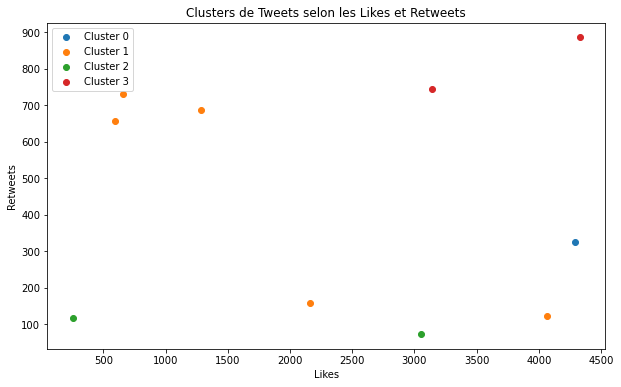

In [24]:
# Visualisation simple des clusters
plt.figure(figsize=(10, 6))
for cluster in range(4):
    cluster_data = df_tweets[df_tweets['Cluster'] == cluster]
    plt.scatter(cluster_data['Likes'], cluster_data['Retweets'],
               label=f'Cluster {cluster}')

plt.xlabel('Likes')
plt.ylabel('Retweets')
plt.title('Clusters de Tweets selon les Likes et Retweets')
plt.legend()
plt.show()